In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

tf.set_random_seed(777)

1.12.0


In [2]:
learning_rate = 0.0002
training_epochs = 300
batch_size = 100
noise_dim = 128
n_class = 10

In [3]:
#mnist = keras.datasets.mnist
#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist = keras.datasets.fashion_mnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(train_images, train_labels), (_, _) = mnist.load_data()

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
    buffer_size=100000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()

In [6]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

In [7]:
train_init = iterator.make_initializer(train_dataset)

In [8]:
vec_images = tf.reshape(images, [-1, 28, 28, 1])
vec_images = tf.cast(vec_images, tf.float32) / 255.
onehot_labels = tf.one_hot(labels, n_class)

In [9]:
Z = tf.placeholder(tf.float32, [None, noise_dim])

In [10]:
def generator(noise, label):
    with tf.variable_scope('generator') as scope:
        inputs = tf.concat([noise, label], axis=-1)
        print(inputs)
        gen1 = tf.layers.dense(inputs=inputs,
                               units=1024,
                               activation=tf.nn.leaky_relu,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen1)
        gen2 = tf.layers.dense(inputs=gen1,
                               units=7*7*64,
                               activation=tf.nn.leaky_relu,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen2)
        gen2 = tf.reshape(gen2, [-1, 7, 7, 64])
        print(gen2)
        gen3 = tf.layers.conv2d_transpose(inputs=gen2,
                                          filters=64,
                                          kernel_size=[5,5],
                                          strides=(2,2),
                                          padding='same',
                                          activation=tf.nn.leaky_relu,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen3)
        gen4 = tf.layers.conv2d_transpose(inputs=gen3,
                                          filters=1,
                                          kernel_size=[5,5],
                                          strides=(2,2),
                                          padding='same',
                                          activation=tf.nn.sigmoid,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(gen4)
        return gen4

In [11]:
def discriminator(image, label, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        #inputs = tf.concat([image, label], axis=1)
        image_shape = image.get_shape()
        label_shape = label.get_shape()
        label_reshape = tf.reshape(label, [-1, 1, 1, label_shape[1]])
        inputs = tf.concat([image, label_reshape*tf.ones(
            [batch_size, image_shape[1], image_shape[2], label_shape[1]])], axis=-1)
        print(inputs)
        dis1 = tf.layers.conv2d(inputs=inputs,
                                filters=32,
                                kernel_size=[5,5],
                                strides=(2,2),
                                padding='same',
                                activation=tf.nn.leaky_relu,
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis1)
        dis2 = tf.layers.conv2d(inputs=dis1,
                                filters=64,
                                kernel_size=[5,5],
                                strides=(2,2),
                                padding='same',
                                activation=tf.nn.leaky_relu,
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis2)
        dis2 = tf.layers.flatten(dis2)
        print(dis2)
        dis3 = tf.layers.dense(inputs=dis2,
                               units=256,
                               activation=tf.nn.leaky_relu,
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis3)
        dis4 = tf.layers.dense(inputs=dis3,
                               units=1,                               
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        print(dis4)
        return dis4

In [12]:
def get_noise(batch_size, noise_dim):
    return np.random.uniform(-1., 1., size=[batch_size, noise_dim])

In [13]:
G = generator(Z, onehot_labels)

Tensor("generator/concat:0", shape=(?, 138), dtype=float32)
Tensor("generator/dense/LeakyRelu:0", shape=(?, 1024), dtype=float32)
Tensor("generator/dense_1/LeakyRelu:0", shape=(?, 3136), dtype=float32)
Tensor("generator/Reshape:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("generator/conv2d_transpose/LeakyRelu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("generator/conv2d_transpose_1/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)


In [14]:
D_real = discriminator(vec_images, onehot_labels)

Tensor("discriminator/concat:0", shape=(100, 28, 28, 11), dtype=float32)
Tensor("discriminator/conv2d/LeakyRelu:0", shape=(100, 14, 14, 32), dtype=float32)
Tensor("discriminator/conv2d_1/LeakyRelu:0", shape=(100, 7, 7, 64), dtype=float32)
Tensor("discriminator/flatten/Reshape:0", shape=(100, 3136), dtype=float32)
Tensor("discriminator/dense/LeakyRelu:0", shape=(100, 256), dtype=float32)
Tensor("discriminator/dense_1/BiasAdd:0", shape=(100, 1), dtype=float32)


In [15]:
D_fake = discriminator(G, onehot_labels, True)

Tensor("discriminator_1/concat:0", shape=(100, 28, 28, 11), dtype=float32)
Tensor("discriminator_1/conv2d/LeakyRelu:0", shape=(100, 14, 14, 32), dtype=float32)
Tensor("discriminator_1/conv2d_1/LeakyRelu:0", shape=(100, 7, 7, 64), dtype=float32)
Tensor("discriminator_1/flatten/Reshape:0", shape=(100, 3136), dtype=float32)
Tensor("discriminator_1/dense/LeakyRelu:0", shape=(100, 256), dtype=float32)
Tensor("discriminator_1/dense_1/BiasAdd:0", shape=(100, 1), dtype=float32)


In [16]:
loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=D_real, labels=tf.ones_like(D_real)))
loss_D_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=D_fake, labels=tf.zeros_like(D_fake)))

In [17]:
loss_D = loss_D_real + loss_D_fake

In [18]:
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_fake, labels=tf.ones_like(D_fake)))

In [19]:
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

In [20]:
train_D = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_G, var_list=vars_G)

In [21]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(tf.global_variables_initializer())

Training Start


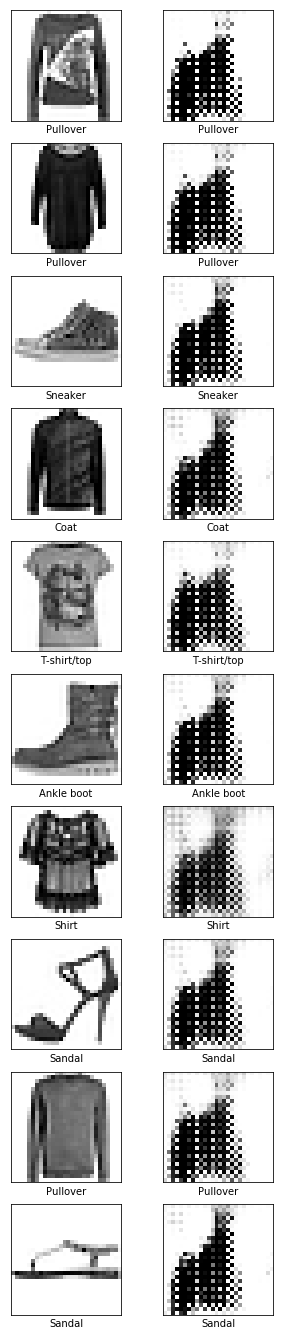

Epoch: 10 loss_D = 1.20624362 loss_G = 1.18132344


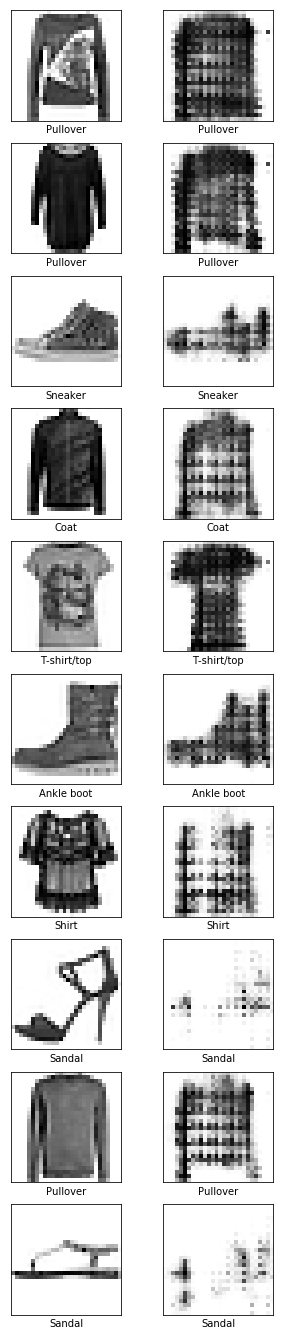

Epoch: 20 loss_D = 1.34726298 loss_G = 1.06464435


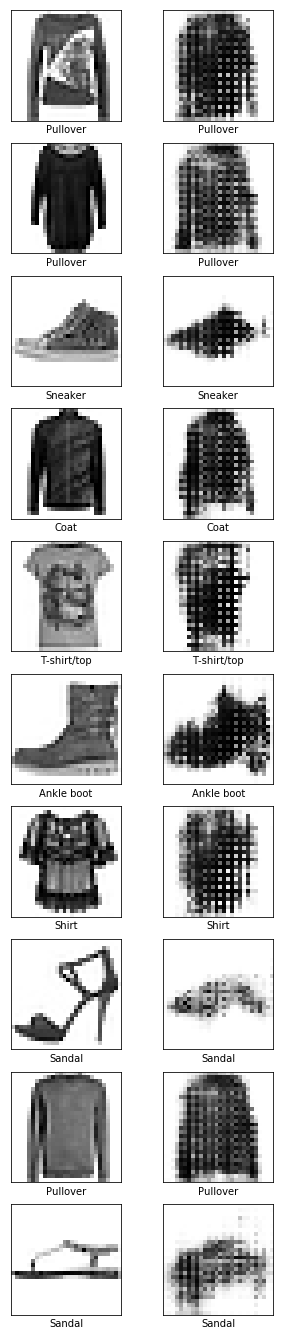

Epoch: 30 loss_D = 1.32860318 loss_G = 0.82459115


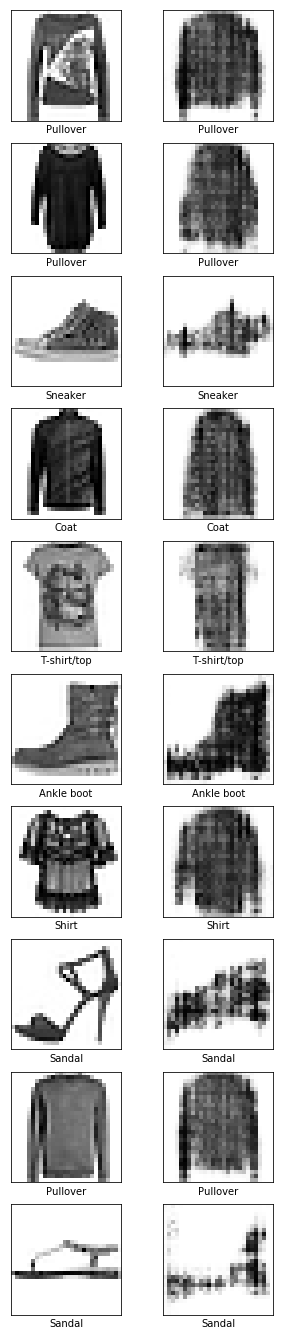

Epoch: 40 loss_D = 1.33297613 loss_G = 0.84872808


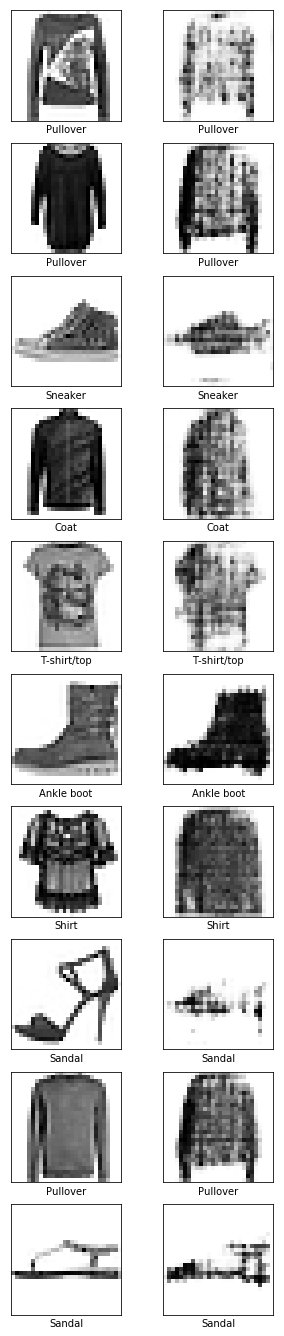

Epoch: 50 loss_D = 1.35586289 loss_G = 0.78103367


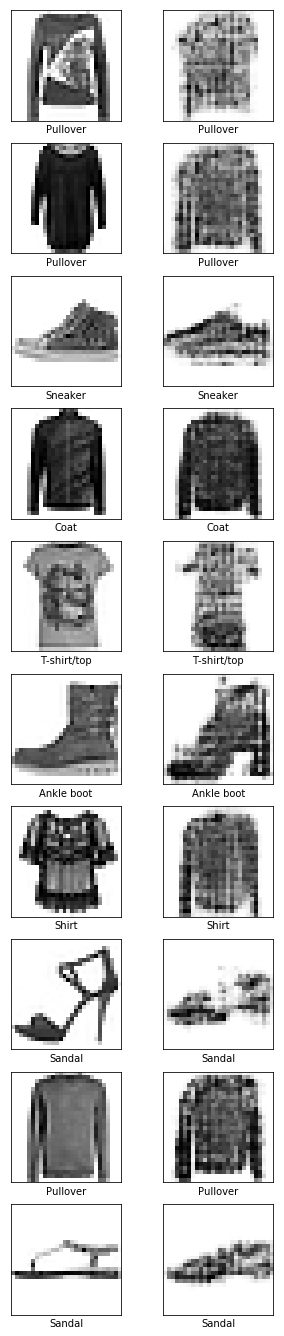

Epoch: 60 loss_D = 1.33884777 loss_G = 0.78272884


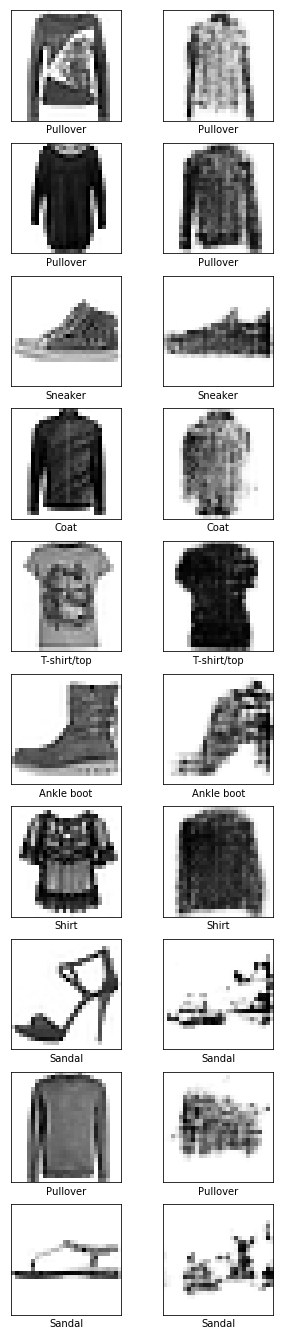

Epoch: 70 loss_D = 1.35348780 loss_G = 0.77377412


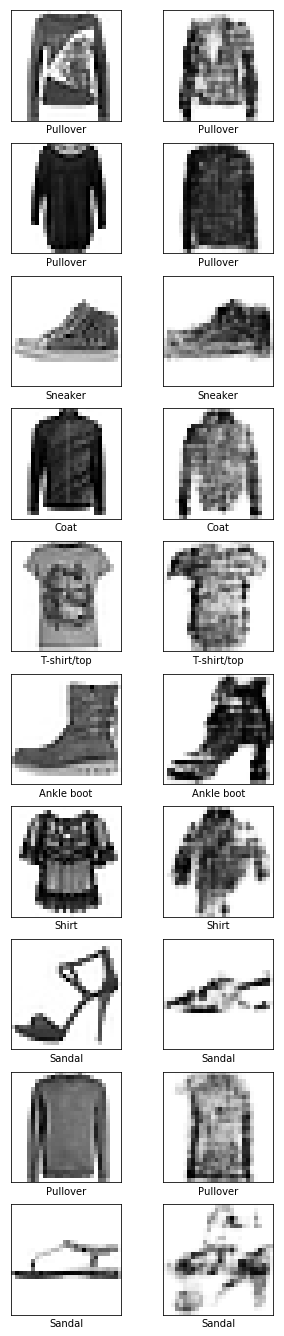

Epoch: 80 loss_D = 1.35276176 loss_G = 0.77135947


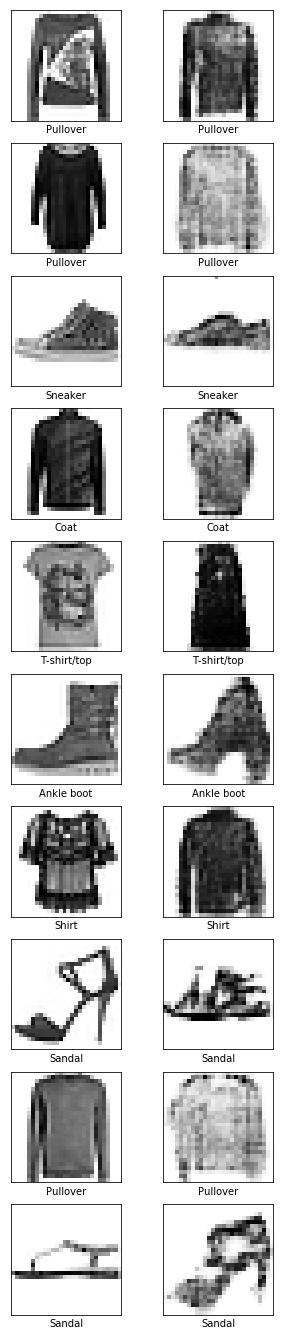

Epoch: 90 loss_D = 1.35477063 loss_G = 0.76614204


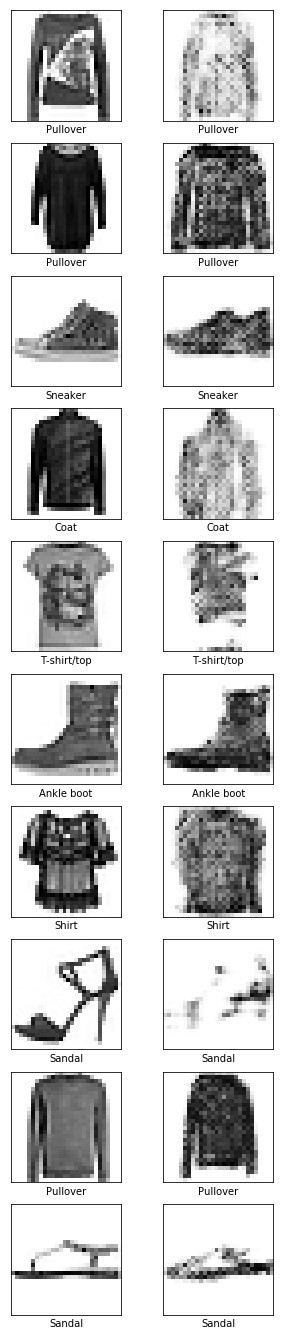

Epoch: 100 loss_D = 1.35708938 loss_G = 0.76595127


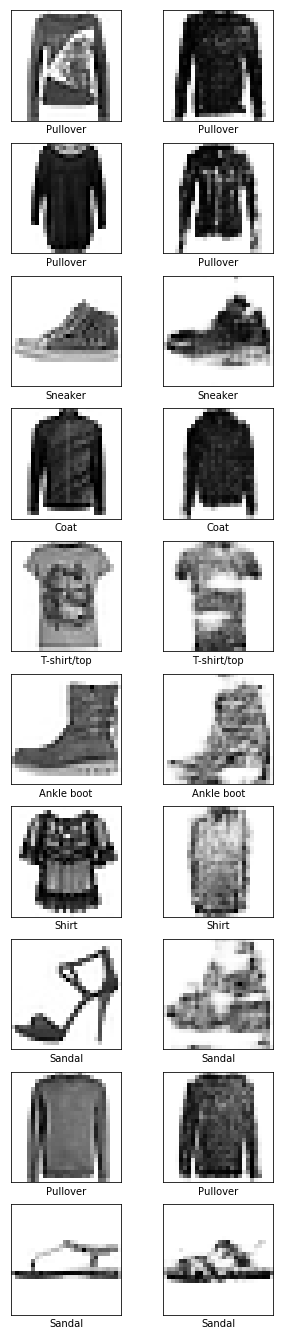

Epoch: 110 loss_D = 1.35765803 loss_G = 0.77275211


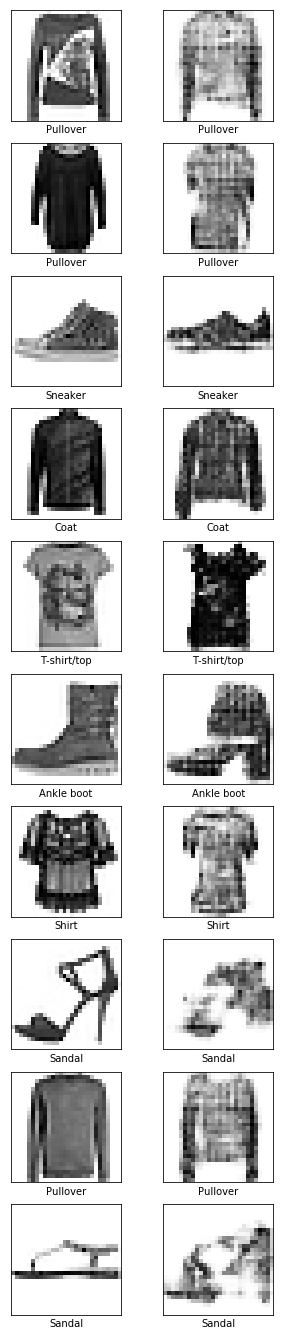

Epoch: 120 loss_D = 1.35345601 loss_G = 0.77030224


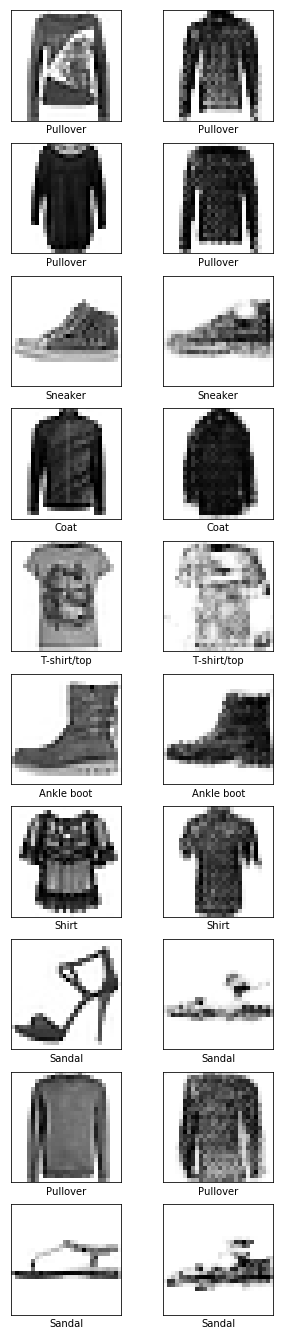

Epoch: 130 loss_D = 1.36261046 loss_G = 0.74649990


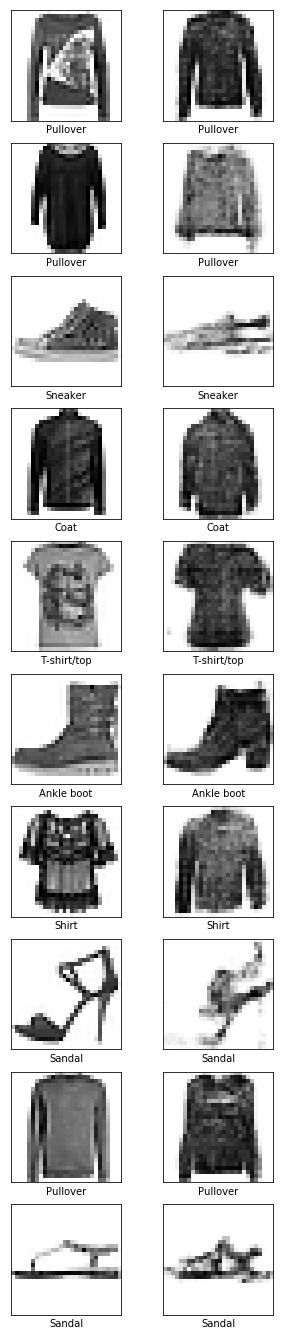

Epoch: 140 loss_D = 1.36319460 loss_G = 0.74435958


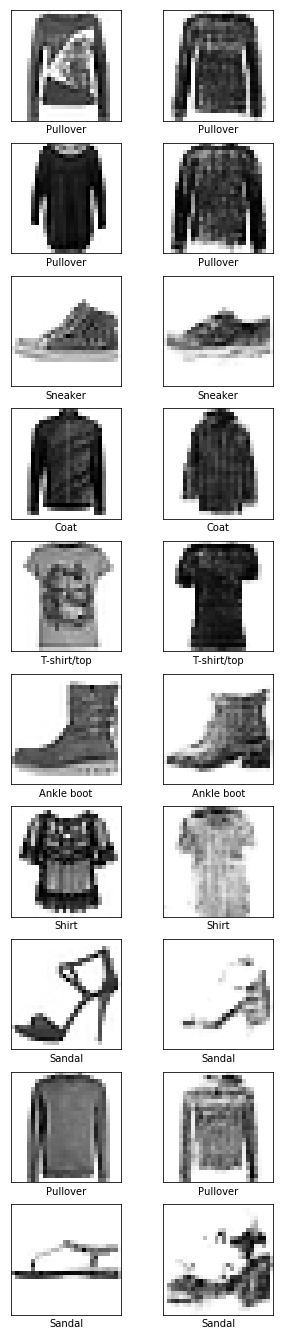

Epoch: 150 loss_D = 1.35786759 loss_G = 0.76059602


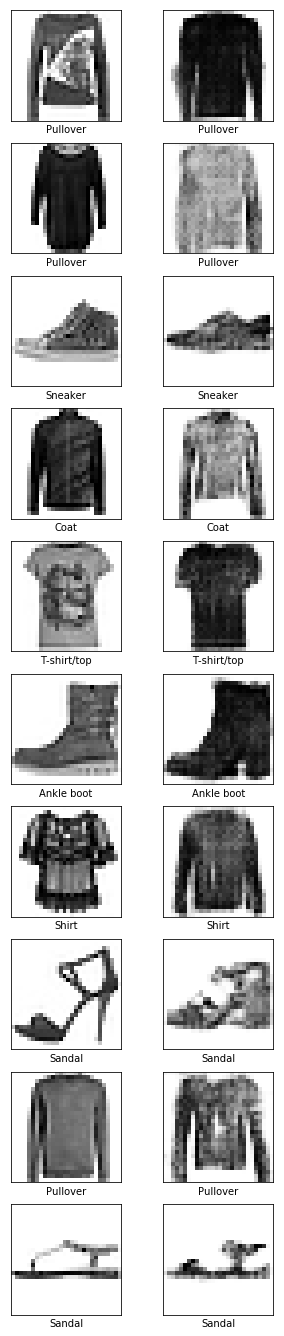

Epoch: 160 loss_D = 1.36989541 loss_G = 0.74027151


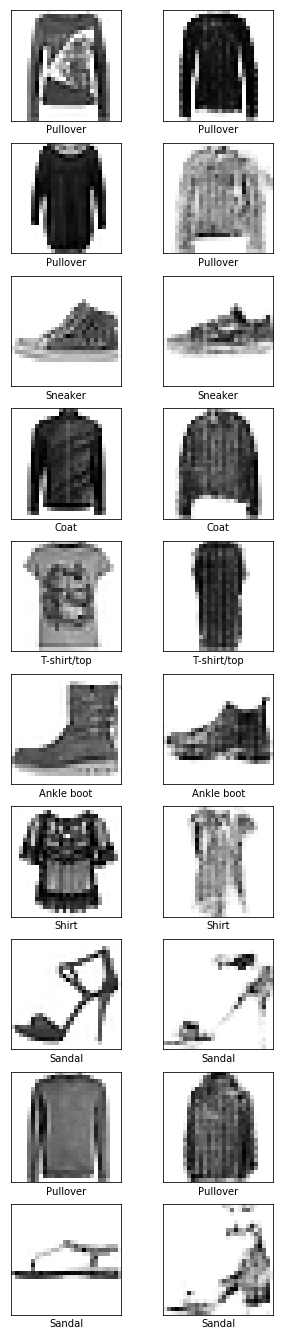

Epoch: 170 loss_D = 1.36792716 loss_G = 0.74187044


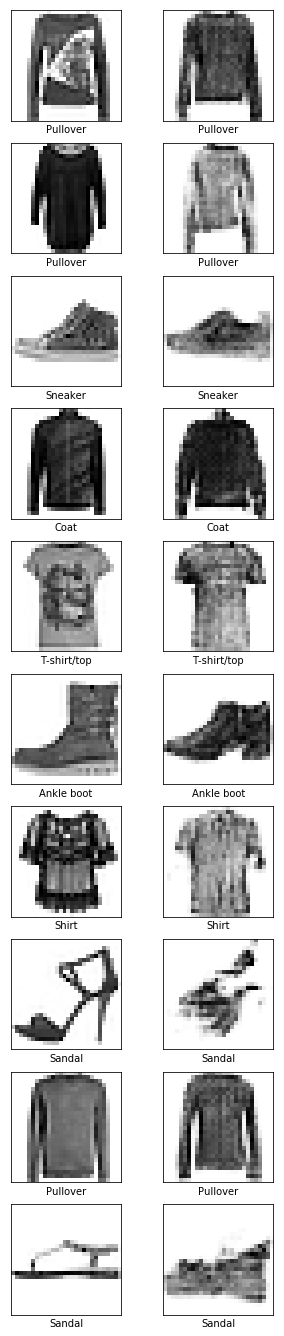

Epoch: 180 loss_D = 1.36106847 loss_G = 0.75375710


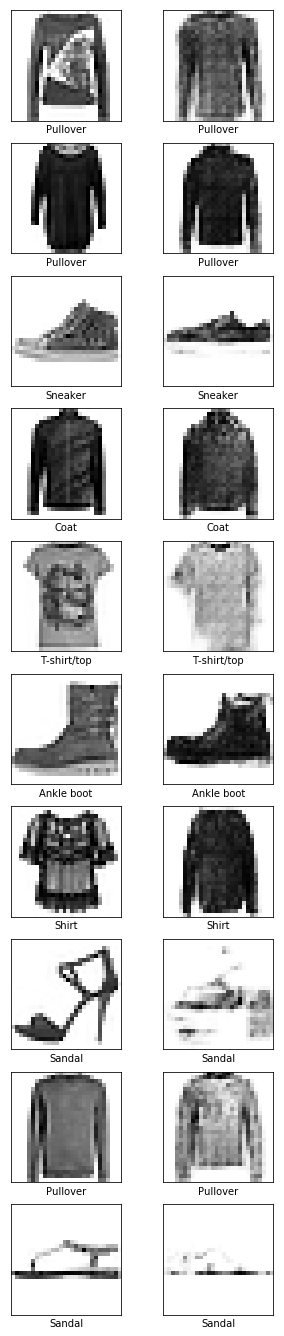

Epoch: 190 loss_D = 1.36058520 loss_G = 0.74739284


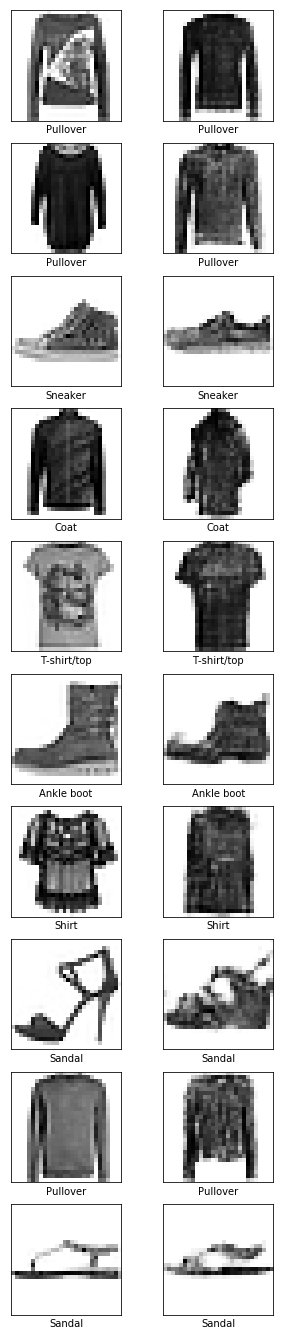

Epoch: 200 loss_D = 1.36512848 loss_G = 0.73915055


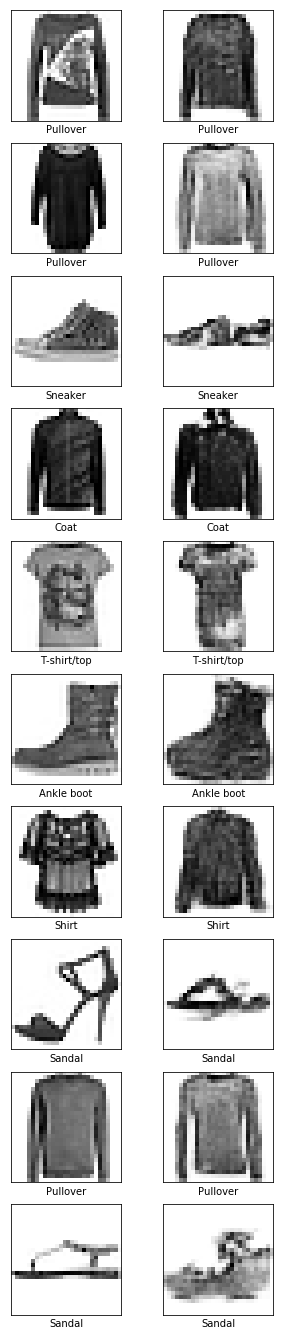

Epoch: 210 loss_D = 1.36301477 loss_G = 0.74705758


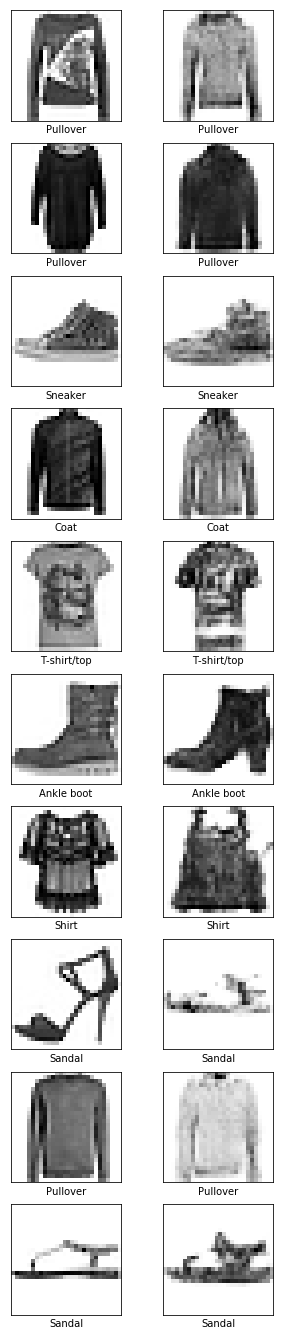

Epoch: 220 loss_D = 1.35874731 loss_G = 0.75892403


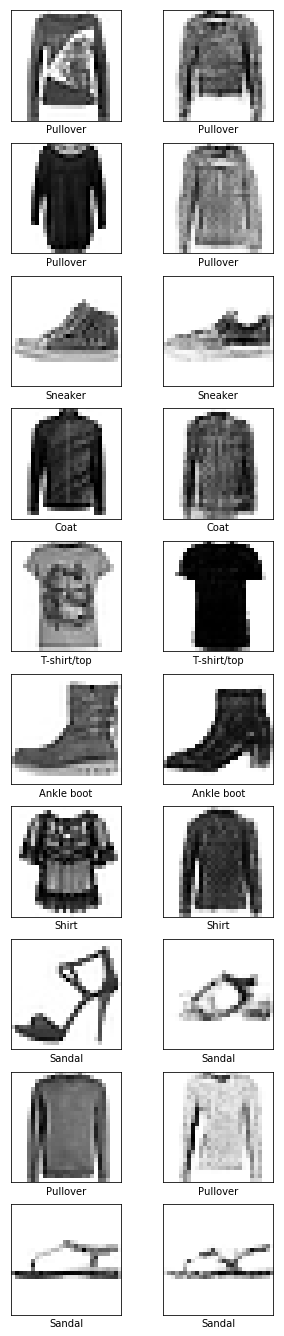

Epoch: 230 loss_D = 1.35398275 loss_G = 0.75896304


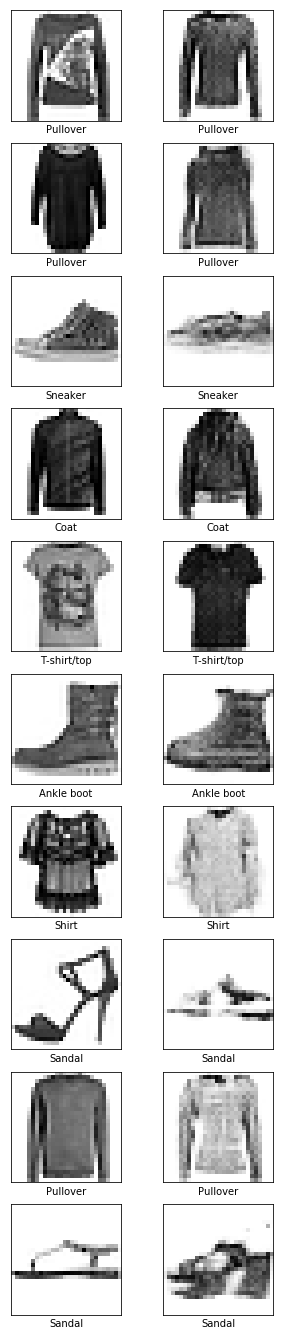

Epoch: 240 loss_D = 1.36023765 loss_G = 0.74723341


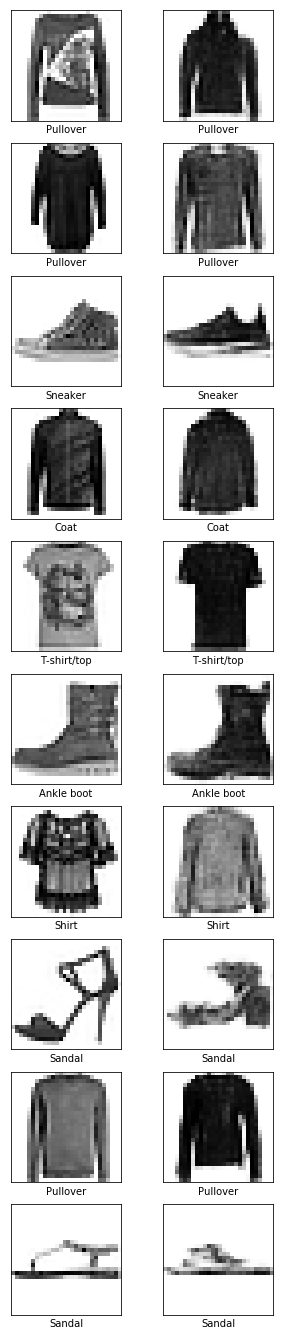

Epoch: 250 loss_D = 1.35949442 loss_G = 0.74724976


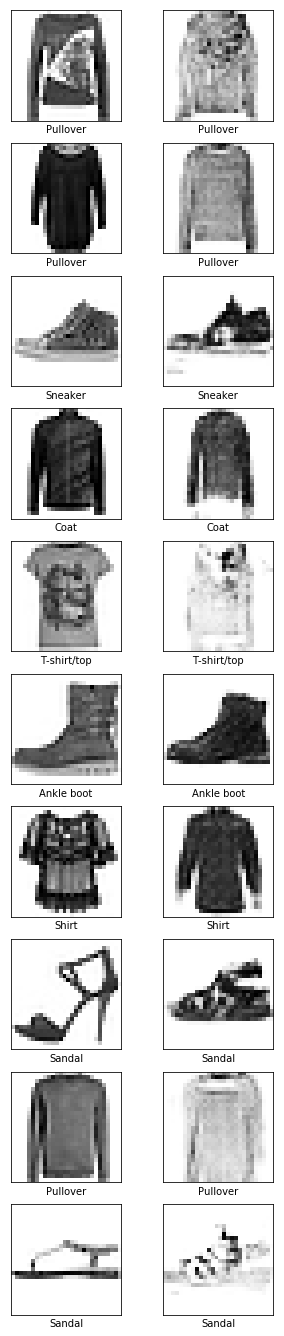

Epoch: 260 loss_D = 1.36088160 loss_G = 0.73902527


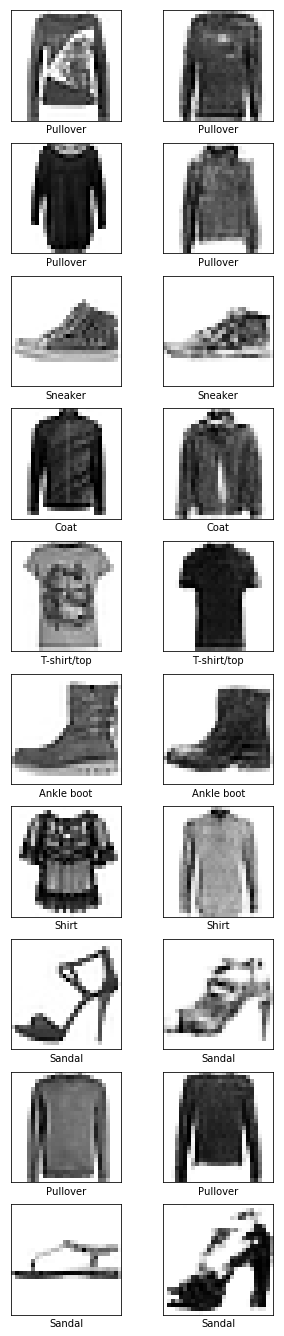

Epoch: 270 loss_D = 1.35557680 loss_G = 0.74972583


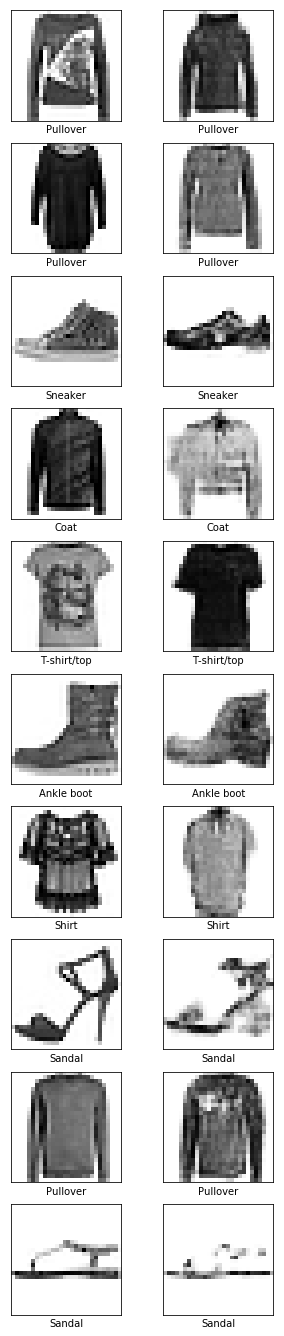

Epoch: 280 loss_D = 1.35579730 loss_G = 0.75379520


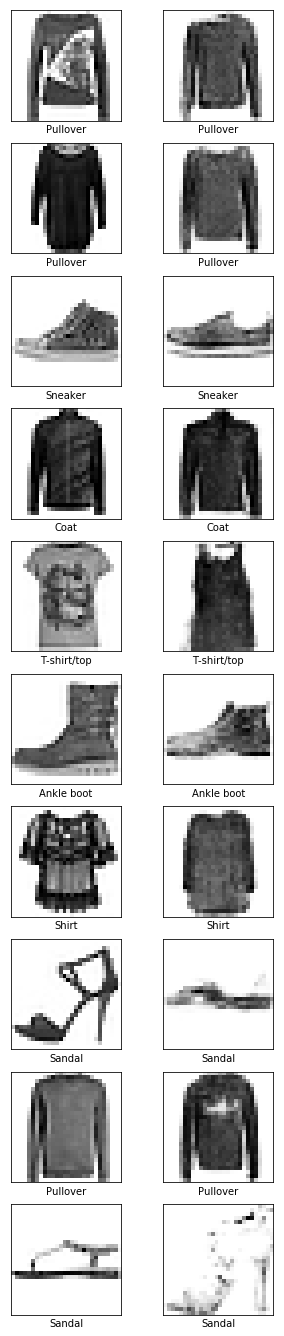

Epoch: 290 loss_D = 1.34619865 loss_G = 0.76615362


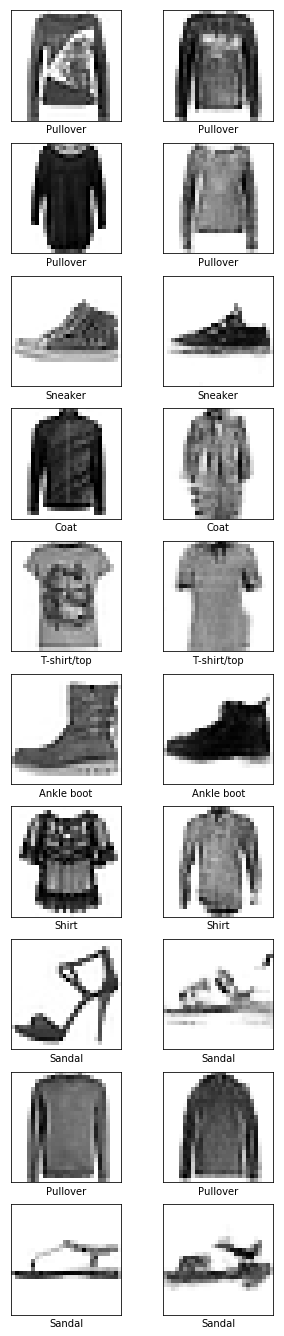

Epoch: 300 loss_D = 1.35167354 loss_G = 0.75571469


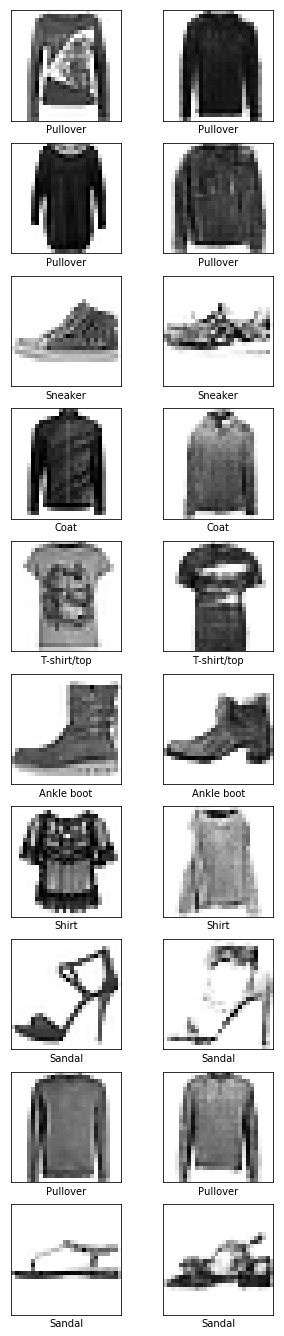

In [22]:
print('Training Start')
for epoch in range(training_epochs):
    avg_loss_D = 0.
    avg_loss_G = 0.
    total_batch = int(train_images.shape[0] / batch_size)    
    
    sess.run(train_init)
    noise = get_noise(batch_size, noise_dim)
    
    for i in range(total_batch):
        _, l_D = sess.run([train_D, loss_D], feed_dict={Z: noise})
        _, l_G = sess.run([train_G, loss_G], feed_dict={Z: noise})
        avg_loss_D += l_D / total_batch
        avg_loss_G += l_G / total_batch
    
    if (epoch+1) % 10 == 0:
        print('Epoch:', '{}'.format(epoch + 1),
              'loss_D =', '{:.8f}'.format(avg_loss_D),
              'loss_G =', '{:.8f}'.format(avg_loss_G))
    if epoch == 0 or (epoch+1) % 10 == 0:
        sample_size = 10
        sess.run(train_init)
        noise = get_noise(sample_size, noise_dim)
        imgs, lbs = sess.run([images, labels])        
        #print(noise)
        samples = sess.run(G, feed_dict={Z: noise, labels: lbs[:sample_size]})
        samples = np.reshape(samples, (-1, 28, 28))
        #print(samples)
        
        plt.figure(figsize=(5,24))
        for i in range(sample_size):
            plt.subplot(sample_size, 2, i*2+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(np.reshape(imgs[i], (28, 28)), cmap=plt.cm.binary)
            plt.xlabel(class_names[lbs[i]])
            plt.subplot(sample_size, 2,(i+1)*2)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(np.reshape(samples[i], (28, 28)), cmap=plt.cm.binary)
            plt.xlabel(class_names[lbs[i]])
        plt.show()